In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import matplotlib.pyplot as plt


2026-02-11 05:42:14.929403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770788535.111276      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770788535.162572      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770788535.576885      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770788535.576928      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770788535.576931      55 computation_placer.cc:177] computation placer alr

In [2]:
import os
print(os.listdir("/kaggle/input/datasets"))
print(os.listdir("/kaggle/input/datasets/ruizgara"))
print(os.listdir("/kaggle/input/datasets/ruizgara/socofing"))
print(os.listdir("/kaggle/input/datasets/ruizgara/socofing/SOCOFing"))


['ruizgara']
['socofing']
['SOCOFing', 'socofing']
['Real', 'Altered']


In [3]:
import os
import shutil

source_base = "/kaggle/input/datasets/ruizgara/socofing/SOCOFing"

real_src = os.path.join(source_base, "Real")
altered_easy_src = os.path.join(source_base, "Altered/Altered-Easy")

new_base = "/kaggle/working/binary_dataset"

real_dst = os.path.join(new_base, "Real")
altered_dst = os.path.join(new_base, "Altered-Easy")

os.makedirs(real_dst, exist_ok=True)
os.makedirs(altered_dst, exist_ok=True)


In [4]:
# Copy Real
for file in os.listdir(real_src):
    shutil.copy(os.path.join(real_src, file), real_dst)

# Copy Altered-Easy
for file in os.listdir(altered_easy_src):
    shutil.copy(os.path.join(altered_easy_src, file), altered_dst)

print("Dataset Prepared!")


Dataset Prepared!


### Check Class Imbalance

In [5]:
real_count = len(os.listdir(real_dst))
altered_count = len(os.listdir(altered_dst))

print("Real images:", real_count)
print("Altered-Easy images:", altered_count)


Real images: 6000
Altered-Easy images: 17931


In [6]:
import os
import shutil
import random

base_dir = "/kaggle/working/binary_dataset"

real_src = os.path.join(base_dir, "Real")
altered_src = os.path.join(base_dir, "Altered-Easy")

split_base = "/kaggle/working/split_dataset"

for split in ["train", "val", "test"]:
    for cls in ["Real", "Altered-Easy"]:
        os.makedirs(os.path.join(split_base, split, cls), exist_ok=True)


In [7]:
def split_data(source, train_dir, val_dir, test_dir):

    files = os.listdir(source)
    random.shuffle(files)

    total = len(files)
    train_end = int(0.7 * total)
    val_end = int(0.85 * total)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    for f in train_files:
        shutil.copy(os.path.join(source, f), train_dir)

    for f in val_files:
        shutil.copy(os.path.join(source, f), val_dir)

    for f in test_files:
        shutil.copy(os.path.join(source, f), test_dir)


In [8]:
split_data(
    real_src,
    os.path.join(split_base, "train/Real"),
    os.path.join(split_base, "val/Real"),
    os.path.join(split_base, "test/Real")
)

split_data(
    altered_src,
    os.path.join(split_base, "train/Altered-Easy"),
    os.path.join(split_base, "val/Altered-Easy"),
    os.path.join(split_base, "test/Altered-Easy")
)

print("Splitting Completed ✅")


Splitting Completed ✅


In [9]:
for split in ["train", "val", "test"]:
    print("\n", split.upper())
    for cls in ["Real", "Altered-Easy"]:
        path = os.path.join(split_base, split, cls)
        print(cls, ":", len(os.listdir(path)))



 TRAIN
Real : 4200
Altered-Easy : 12551

 VAL
Real : 900
Altered-Easy : 2690

 TEST
Real : 900
Altered-Easy : 2690


### Handle Imbalance Automatically (Class Weights)

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = [0]*altered_count + [1]*real_count  # 0 = Altered, 1 = Real

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.6673080140538732), 1: np.float64(1.99425)}


### Create Generators

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(split_base, "train"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_base, "val"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(split_base, "test"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 16751 images belonging to 2 classes.
Found 3590 images belonging to 2 classes.
Found 3590 images belonging to 2 classes.


### Build CNN Model

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))   # Binary output

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1770789445.669063      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1770789462.332013     207 service.cc:152] XLA service 0x79cca0005670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770789462.332046     207 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770789462.740420     207 cuda_dnn.cc:529] Loaded cuDNN version 91002


 10/524 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.3799 - loss: 1.0836

I0000 00:00:1770789465.776933     207 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


524/524 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.5576 - loss: 0.6823 - val_accuracy: 0.7496 - val_loss: 0.4860
Epoch 2/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8211 - loss: 0.3779 - val_accuracy: 0.8557 - val_loss: 0.2778
Epoch 3/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8795 - loss: 0.2315 - val_accuracy: 0.9092 - val_loss: 0.2159
Epoch 4/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.8996 - loss: 0.1961 - val_accuracy: 0.9432 - val_loss: 0.1464
Epoch 5/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9390 - loss: 0.1428 - val_accuracy: 0.9214 - val_loss: 0.1920
Epoch 6/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.9507 - loss: 0.1193 - val_accuracy: 0.9613 - val_loss: 0.1124
Epoch 7/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.9576 - loss: 0.1084 - val_accuracy: 0.9521 - val_loss: 0.1406
Epoch 8/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9651 - loss: 0.0881 - val_accurac

In [14]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9603 - loss: 0.1048
Test Accuracy: 0.9632312059402466


In [15]:
model.save("/kaggle/working/fingerprint_altered_easy_vs_real.h5")
print("Model saved successfully ✅")


Model saved successfully ✅


In [16]:
import shutil

test_path = "/kaggle/working/split_dataset/test"
zip_path = "/kaggle/working/test_dataset.zip"

shutil.make_archive(zip_path.replace(".zip",""), 'zip', test_path)

print("Test dataset zipped successfully ✅")


Test dataset zipped successfully ✅


In [23]:
import shutil

test_path = "/kaggle/working/split_dataset/val"
zip_path = "/kaggle/working/valdataset.zip"

shutil.make_archive(zip_path.replace(".zip",""), 'zip', test_path)

print("val dataset zipped successfully ✅")


val dataset zipped successfully ✅


In [24]:
import shutil

test_path = "/kaggle/working/split_dataset/train"
zip_path = "/kaggle/working/traindataset.zip"

shutil.make_archive(zip_path.replace(".zip",""), 'zip', test_path)

print("val dataset zipped successfully ✅")


val dataset zipped successfully ✅


In [17]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

test_path = "/kaggle/working/split_dataset/test"

for class_name in ["Real", "Altered-Easy"]:
    
    folder_path = os.path.join(test_path, class_name)
    files = os.listdir(folder_path)
    
    print(f"\nChecking images in: {class_name}")
    
    for file in files[:10]:   # remove [:10] to test all images
        
        img_path = os.path.join(folder_path, file)
        
        img = image.load_img(img_path, target_size=(128,128))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        prediction = model.predict(img_array)[0][0]
        
        if prediction > 0.5:
            predicted_label = "Real"
            confidence = prediction
        else:
            predicted_label = "Altered-Easy"
            confidence = 1 - prediction
        
        print(f"Image: {file}")
        print(f"Actual: {class_name}")
        print(f"Predicted: {predicted_label}")
        print(f"Confidence: {round(confidence*100,2)}%")
        print("-"*40)



Checking images in: Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
Image: 163__M_Left_ring_finger.BMP
Actual: Real
Predicted: Real
Confidence: 99.30999755859375%
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: 291__M_Left_middle_finger.BMP
Actual: Real
Predicted: Real
Confidence: 99.91999816894531%
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: 183__M_Right_index_finger.BMP
Actual: Real
Predicted: Real
Confidence: 99.88999938964844%
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Image: 280__M_Left_middle_finger.BMP
Actual: Real
Predicted: Real
Confidence: 99.88999938964844%
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image: 45__M_Left_thumb_finger.BMP
Actual: Real
Predicted: Real
Confidence: 99.72000122070312%
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image: 447__M_Right_middle_finger.BMP
Actual: Real
Predicte

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction: Real
Confidence: 99.61 %


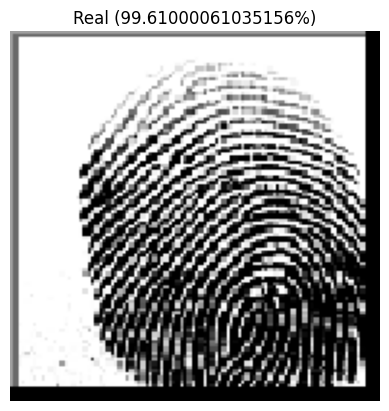

In [21]:
img_path ="/kaggle/working/split_dataset/test/Real/100__M_Left_little_finger.BMP"
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_single_image(img_path):

    img = image.load_img(img_path, target_size=(128,128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]

    if prediction > 0.5:
        label = "Real"
        confidence = prediction
    else:
        label = "Altered-Easy"
        confidence = 1 - prediction

    print("Prediction:", label)
    print("Confidence:", round(confidence*100,2), "%")

    plt.imshow(img)
    plt.title(f"{label} ({round(confidence*100,2)}%)")
    plt.axis("off")
    plt.show()
predict_single_image(img_path)


In [25]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9603 - loss: 0.1048
Test Accuracy: 0.9632312059402466
Test Loss: 0.09489692002534866


In [26]:
from sklearn.metrics import classification_report
import numpy as np

test_generator.reset()
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype(int)

print(classification_report(
    test_generator.classes,
    pred_labels,
    target_names=["Altered-Easy", "Real"]
))


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
              precision    recall  f1-score   support

Altered-Easy       0.99      0.96      0.97      2690
        Real       0.88      0.98      0.93       900

    accuracy                           0.96      3590
   macro avg       0.94      0.97      0.95      3590
weighted avg       0.97      0.96      0.96      3590



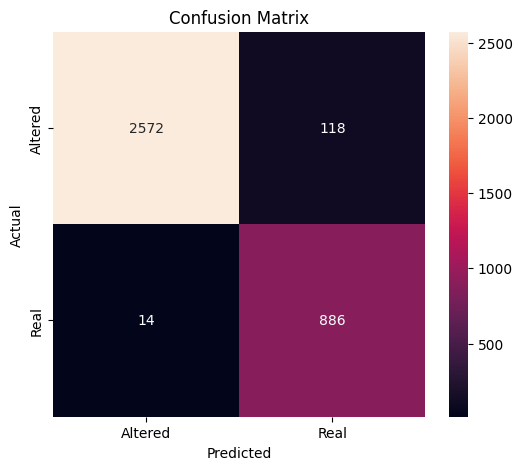

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_generator.classes, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Altered", "Real"],
            yticklabels=["Altered", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


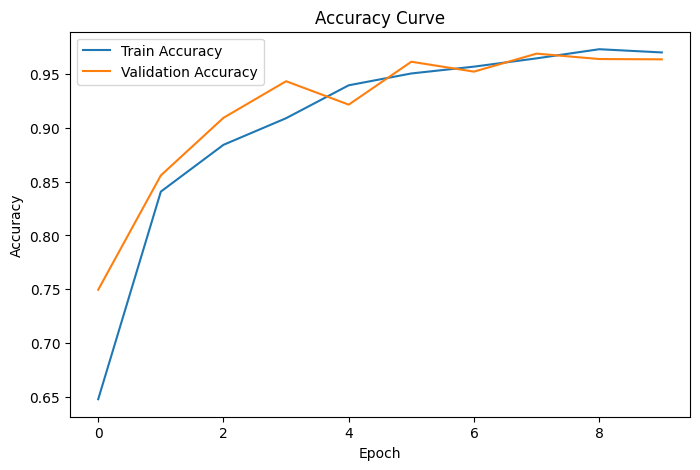

In [28]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


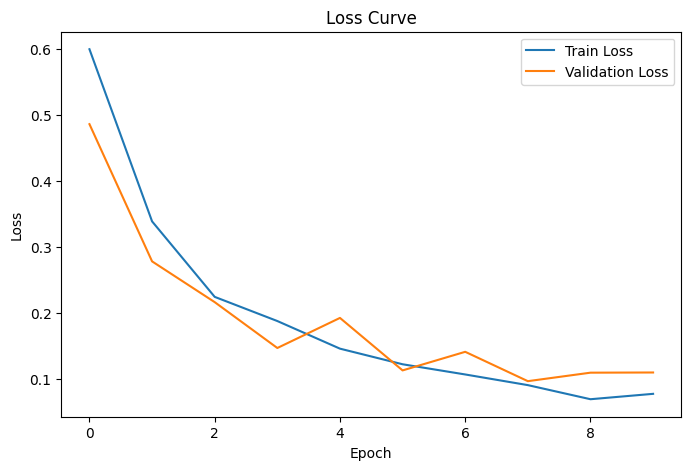

In [29]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
